In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab as pl
import itertools as it

from sklearn.neighbors import NearestNeighbors
from Lorentz import Lorentz
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

d:\misc\python 3.8.1\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
x, _, _ = Lorentz().generate(0.1, 100000)
x = (x - x.min()) / (x.max() - x.min())

In [3]:
split = 900
steps = 0

In [4]:
def generate_train_data(time_series):
    col1 = np.zeros(1000, dtype = np.int32).reshape(-1, 1)
    col2 = np.repeat(np.arange(1, 11, dtype = np.int32), 100).reshape(-1, 1)
    col3 = (np.repeat(np.arange(1, 11, dtype = np.int32), 10) + col2[::100]).reshape(-1, 1)
    col4 = (np.arange(1, 11, dtype = np.int32) + col3[::10]).reshape(-1, 1)

    templates = np.hstack((col1, col2, col3, col4))
    template_shapes = templates[:, 1:] - templates[:, :-1]
    
    x_dim, y_dim, z_dim = templates.shape[0], time_series.size - templates[0][-1], 4
        
    vector_data = np.full(shape = (x_dim, y_dim, z_dim), fill_value = np.inf, dtype = np.float)

    for i in range(x_dim):
        data = time_series[templates[i] + np.arange(time_series.size - templates[i][-1])[:, None]]
        vector_data[i, :data.shape[0]] = data
        
    return vector_data

In [5]:
vector_data = generate_train_data(x[:split])

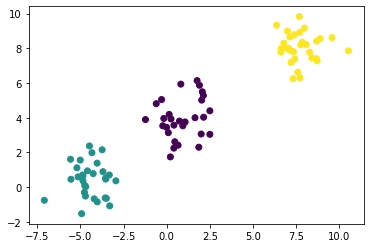

In [6]:
X, y = make_blobs(n_samples = 90, centers = 3, random_state = 3)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y)

In [34]:
def clusterize(data: np.ndarray, k: int, h: float) -> np.ndarray:
    ndim = data.shape[-1]
    n = data.shape[0]
    
    nbrs = NearestNeighbors(n_neighbors = k + 1).fit(data)
    distances, neighbors = nbrs.kneighbors(data)
    distances, neighbors = distances[:, 1:], neighbors[:, 1:]
    total_points_num = distances.shape[0]

    indexes = np.argsort(distances[:, -1])
    distance_matrix = squareform(pdist(data))[indexes]

    graph = np.full(shape = total_points_num, fill_value = -1)
    labels = np.full(shape = total_points_num, fill_value = -1)
    is_formed = {-1: True}
    significance = {-1: np.inf}
    p_values = k / ((((np.pi ** (ndim / 2)) / (math.gamma(ndim / 2 + 1))) * (distances[:, -1] ** ndim)) * n)
    
    cluster_number = 0
    for i, index in zip(range(total_points_num), indexes):
        dk = distances[index][-1] # расстояние до к-ближайшего соседа для текущей точки
        good_points = neighbors[index][:i][distances[index][:i] < dk] # индексы соседей на расстоянии < dk от текущей точки
        neighbors_in_graph = neighbors[index][np.in1d(neighbors[index], graph[:i])] # соседи которые уже в графе
        labels_of_neighbors_in_graph = labels[neighbors_in_graph][labels[neighbors_in_graph] != -1] # их кластера
        
#         plt.figure(figsize = (20, 10))
#         plt.grid()
#         plt.scatter(X[:, 0], X[:, 1], s = 64, c = labels)
#         plt.scatter(X[index][0], X[index][1], s = 64, c = 'red')

#         x_values = np.hstack((np.repeat(X[index][0], k).reshape(-1, 1), X[neighbors[index]][:, 0].reshape(-1, 1)))
#         y_values = np.hstack((np.repeat(X[index][1], k).reshape(-1, 1), X[neighbors[index]][:, 1].reshape(-1, 1)))
        
#         print(f'Точка {index}')
#         print(f'Последний кластер: {cluster_number}')
#         print(f'Ее p-значение: {p_values[index]}')
#         print(f'{k} ближайших соседей: {neighbors[index]}')
#         print(f'Кластера {k} ближайших соседей: {labels[neighbors[index]]}')
#         print(f'Соседи в графе: {neighbors_in_graph}')
#         print(f'Их кластера: {labels_of_neighbors_in_graph}')
#         print(f'Точки в графе на данный момент: \n{graph[:i]}')
#         print(f'Их кластера: {labels[graph[:i]]}')
#         print(f'Значимость кластеров: {significance}')
#         print(f'Сформированность кластеров: {is_formed}')

#         for j in range(k):
#             plt.plot(x_values[j], y_values[j], c = 'red')
        
#         plt.show()
        
        graph[i] = index
        if neighbors_in_graph.size == 0: # если у текущей точки нет соседей в графе
#             print('Точка изолирована')

            labels[index] = cluster_number
            is_formed[cluster_number] = False
            significance[cluster_number] = 0
            cluster_number += 1
            
        else:
            if labels_of_neighbors_in_graph.size == 0:
#                 print('Среди соседей точки только шум')
                labels[index] = -1
            else:
                if all(labels_of_neighbors_in_graph == labels_of_neighbors_in_graph[0]): # если все соседи принадлежат к одному кластеру
                    if is_formed[labels_of_neighbors_in_graph[0]]:
#                         print('Точка не изолирована и среди ее соседей есть только один сформированный кластер')
                        labels[index] = -1
                        
                    else:
#                         print('Точка не изолирована и среди ее соседей есть только один несформированный кластер')

                        labels[index] = labels_of_neighbors_in_graph[0]
                        significance[labels_of_neighbors_in_graph[0]] = max(p_values[labels == labels_of_neighbors_in_graph[0]]) - min(p_values[labels == labels_of_neighbors_in_graph[0]])
                        
                        if significance[labels_of_neighbors_in_graph[0]] > h:
                            is_formed[labels_of_neighbors_in_graph[0]] = True
                
                else:
#                     print('Точка не изолирована и среди ее соседей есть несколько кластеров')

                    significant_neighbor_clusters = []
                    insignificant_neighbor_clusters = []

                    for neighbor in neighbors_in_graph:
                        if significance[labels[neighbor]] > h:
                            significant_neighbor_clusters.append(labels[neighbor])  
                        else:
                            insignificant_neighbor_clusters.append(labels[neighbor])
                            
#                     print(f'Значимые кластера по соседству: {set(significant_neighbor_clusters)}')
#                     print(f'Незначимые кластера по соседству: {set(insignificant_neighbor_clusters)}')

                    if len(set(significant_neighbor_clusters)) == 1: # если есть только один значимый кластер
#                         print('Среди ее соседей есть только один значимый кластер')

                        labels[index] = significant_neighbor_clusters[0]

                        for label in set(insignificant_neighbor_clusters):
                            labels[labels == label] = significant_neighbor_clusters[0]

                        significance[significant_neighbor_clusters[0]] = max(p_values[labels == significant_neighbor_clusters[0]]) - min(p_values[labels == significant_neighbor_clusters[0]])
                        is_formed[significant_neighbor_clusters[0]] = True

                    elif len(set(significant_neighbor_clusters)) > 1:
#                         print('Среди ее соседей больше одного значимого кластера')

                        labels[index] = -1

                        for label in set(significant_neighbor_clusters):
                            is_formed[label] = True

                        for label in set(insignificant_neighbor_clusters):
                            labels[labels == label] = -1

                    else:
#                         print('Не нашлось ни одного значимого кластера')

                        most_significant_cluster_so_far = labels_of_neighbors_in_graph[np.argmax([significance[j] for j in labels_of_neighbors_in_graph[labels_of_neighbors_in_graph != -1]])]
                        labels[index] = most_significant_cluster_so_far

                        for label in set(insignificant_neighbor_clusters):
                            labels[labels == label] = most_significant_cluster_so_far

                        significance[most_significant_cluster_so_far] = max(p_values[labels == most_significant_cluster_so_far]) - min(p_values[labels == most_significant_cluster_so_far])
                        
                        if significance[most_significant_cluster_so_far] > h:
                            is_formed[most_significant_cluster_so_far] = True
        
#         print(f'Кластер текущей точки: {labels[index]}')
#         print(f'Соседи точек уже в графе: \n{neighbors[graph[:i]]}')
#         print(f'Дистанция до {k}-го ближайшего соседа: {dk}')
#         print(f'Their neighbors clusters: \n{labels[neighbors[graph[:i]]]}')
#         print(f'Distances to current neighbors: \n{distance_matrix[:i, index]}')
#         print(f'Indices of current neighbors: \n{neighbors[index][:i]}')
#         print()

#     for key in significance.keys():
#         if significance[key] > h:
#             is_formed[key] = True
#         else:
#             labels[labels == key] = -1

#     print(significance, is_formed)
    return labels

In [35]:
labels = clusterize(X, 7, 0.053)

Всего кластеров: [-1  0  1  2]
Кол-во точек в каждом кластере соответственно: [13 21 26 30]


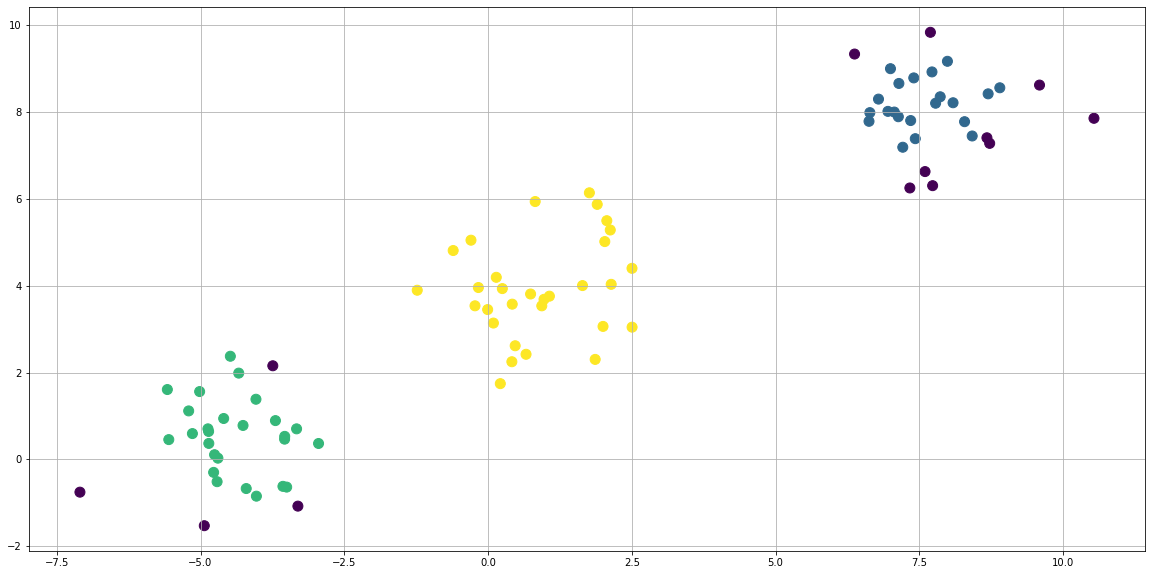

In [36]:
clusters, counts = np.unique(labels, return_counts = True)
print(f'Всего кластеров: {clusters}')
print(f'Кол-во точек в каждом кластере соответственно: {counts}')
plt.figure(figsize = (20, 10))
plt.grid()
plt.scatter(X[:, 0], X[:, 1], s = 100, c = labels)
# plt.scatter(X[:, 0][np.where(labels == 0)[0]], X[:, 1][np.where(labels == 0)[0]], s = 100)

In [37]:
labels_vector_data = clusterize(vector_data[0], 1, 20000000)

Всего кластеров: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

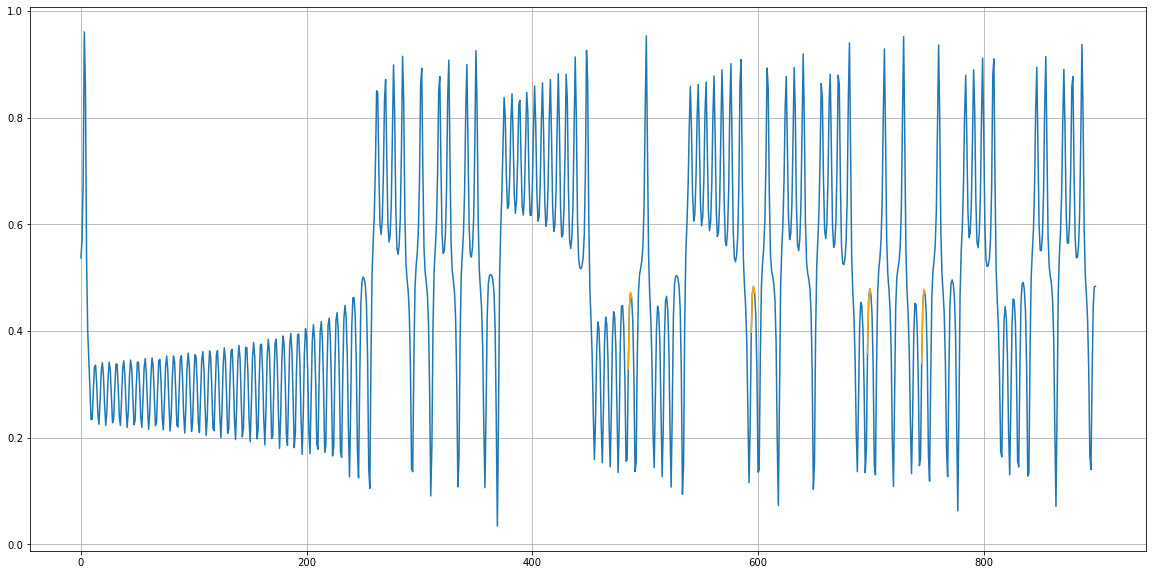

In [38]:
clusters, counts = np.unique(labels_vector_data, return_counts = True)
print(f'Всего кластеров: {clusters}')
print(f'Кол-во точек в каждом кластере соответственно: {counts}')

plt.figure(figsize = (20, 10))
plt.grid()
plt.plot(x[:split])

for i in range(labels_vector_data.size):
    if labels_vector_data[i] == 188:
        plt.plot([i, i + 1, i + 2, i + 3], vector_data[0, i], c = 'orange')
        
plt.show()